# Image retrieval thanks to global image features

A lot of papers are now using deep global features (and not anymore handcrafted features such as SIFTs, which fail in the case of strong style change) to perform image retrieval in historical documents, or pattern matching in artistics datasets - where it is necessary to retrieve images depending on their content, and independently of their "style".

In our case, we are working on a datasets of ~5000 images of Astronomical diagrams (but also of illustrations, false detections, etc. - our segmentation method is not yet optimal!), that we want to explore.

> *Is it possible to easily retrieve similar diagrams from a query one thanks to deep features? What is the best architecture / truncated final layer to do so? Wouldn't it be nice to also develop visualization / clustering tools to navigate in this dataset - and help historians of astronomy find inventive new formal connections between diagrams?*

First of all, let's transform our images into features. For this, we use a `ResNet-50` architecture, and truncate it to output its `conv4` features - each image resized to `320×320`, and is represented by `20×20` features. To find the most "similar" images from a query one, we use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

Please play a little bit with the **network architecture**, the **final layer** choice, and try some **image retrieval queries** - to start understand what it is possible to do with deep features.

First, let's play a little bit with some deep features representations.

> ### *Improving results*
> - Try to enhance input data (remove blank diagrams, annotate manualy manuscripts, etc.)
> - Try different variables, models, truncation, etc.
> - Augment the dataset by considering metadata on extracted diagrams (production date, geographical origin, manuscrit in which the diagram can be found, celectial object/phenomenon represented, etc.)segmentation
>
> ### *Interpreting results*
> - What are telling visualisations?
> - In what context could these techniques be useful?
> - What are the limits of those analyses?

## Resources

### Historical images analysis

#### Historical images segmentation

- [**DocExtractor**](https://arxiv.org/abs/1804.10371): [GitHub](https://www.tmonnier.com/docExtractor/)

#### Deep visual similarities for artistic/historical images retrieval

- [Historical Image Analysis](https://imagine.enpc.fr/~shenx/HisImgAnalysis/)
- [ImageCollation](https://imagine.enpc.fr/~shenx/ImageCollation/)
- [ArtMiner](https://imagine.enpc.fr/~shenx/ArtMiner/)
- [Aesthetic complexity and the evolution of visual art](https://arxiv.org/abs/2205.10271)
- [Art History in the Eyes of the Machine](https://arxiv.org/abs/1801.07729)
- [Astronomical diagrams: detection & grouping by formal ressemblance](https://docs.google.com/presentation/d/1Ebwqq5sH3rEdPkChyQek4f9rmGK9NzB8aaNe_W7JLLA/view?usp=sharing)
- [Visual contagions](https://www.unige.ch/visualcontagions/expositions/jeu-de-paume-le-projet)

### Models

- **ResNet**: [Deep Residual Learning for Image Recognition](https://www.youtube.com/watch?v=GWt6Fu05voI)
- **DeepDream**: [What Is Google Deep Dream?](https://www3.cs.stonybrook.edu/~cse352/T12talk.pdf)
- **CLIP**: [Blog](https://openai.com/blog/clip/), [GitHub](https://github.com/openai/CLIP), [Paper](https://arxiv.org/abs/2103.00020)

In [1]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install -U scikit-learn
%pip install umap-learn
%pip install matplotlib
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git

# ⚠️⚠️⚠️ Please restart your kernel after installation! ⚠️⚠️⚠️

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.6 MB 9.8 MB/s            
     |████████████████████████████████| 297 kB 126.7 MB/s            
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Note: you may need to re

In [2]:
# GLOBAL IMPORTS
import re, glob, os, shutil
from os.path import join, isfile, splitext, basename, dirname, exists
from os import listdir
from PIL import Image
from tqdm import tqdm

import numpy as np
from numpy import dot
from numpy.linalg import norm

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.functional import normalize
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.linear_model import LogisticRegression

In [3]:
# MODELS IMPORT
import torchvision.models as models
import clip

In [4]:
# UTILITY FUNCTIONS
def natural_sort_func(my_list):
    def convert(text):
        if text.isdigit():
            return int(text)
        return text.lower()

    def alphanum_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]

    return sorted(my_list, key=alphanum_key)

def list_folder_images(folder, natural_sort=True):
    image_types = ('jpg', 'tif', 'png', 'bmp')
    paths = [join(root, file)
            for root, dirs, files in os.walk(folder)
            for file in files
        if isfile(join(root, file)) and file.endswith(image_types)]
    if natural_sort:
        paths = natural_sort_func(paths)
    return paths

def get_images_list(folder):
    images_path = list_folder_images(folder)
    return [Image.open(image_path).convert('RGB') for image_path in images_path], images_path

def zip_dir(dir_path):
    shutil.make_archive(f"{dir_path.split('/')[-1]}", 'zip', dir_path)
    
def display_img(img_path, score=""):
    print(img_path)
    print(score)
    display(Image.open(img_path).convert('RGB'))

In [5]:
# MODELS TO COMPARE
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet_50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# vgg = models.vgg16()
# resnet18 = models.resnet18()
clip_model, preprocess = clip.load('ViT-B/32', device)

Using cache found in /home/jupyter-salbouy/.cache/torch/hub/pytorch_vision_v0.6.0


In [6]:
# FEATURES AND SIMILARITY COMPUTATION FUNCTIONS
def compute_features(model, images, size, batch_size, use_cuda=True):
    preprocess = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        # normalize by mean and std of Imagenet
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    tensors = [preprocess(image) for image in images]
    tensors = torch.stack(tensors, dim=0)
    outputs = []
    if torch.cuda.is_available() and use_cuda:
        model.to('cuda')
    model.eval()
    progress_bar = tqdm(total=len(images))
    with torch.no_grad():
        for i in range(int(np.ceil(tensors.shape[0] / batch_size))):
            # take a small batch
            input_batch = tensors[i * batch_size:(i + 1) * batch_size]
            progress_bar.update(input_batch.shape[0])
            # move input to gpu
            if torch.cuda.is_available() and use_cuda:
                input_batch = input_batch.to('cuda')
            # add outputs to a list
            outputs.append(np.stack(model(input_batch).cpu().numpy(), axis=0))
    model.to('cpu')
    progress_bar.close()
    return np.concatenate(outputs, axis=0)

def compute_features_with_CLIP(dataset):
    all_features = []
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = clip_model.encode_image(images.to(device))
            all_features.append(features)
    return torch.cat(all_features).cpu().numpy()

def normalize_feats(feat):
    return feat/np.linalg.norm(feat, 2, axis=-1, keepdims=True)

def compute_cosine_matrix(feats1, feats2):
    feats1 = normalize_feats(feats1.reshape(feats1.shape[0], -1))
    feats2 = normalize_feats(feats2.reshape(feats2.shape[0], -1))
    return feats1.dot(feats2.T)

def get_ordered_scores_matrix(smatrix, axis=1):
    ordered_scores = np.flip(np.argsort(smatrix, axis=axis), axis=axis)
    return ordered_scores

In [7]:
""" VARIABLES TO MODIFY """
model = resnet_50  # vgg, resnet_18, clip_model
model_name = "resnet_50" # vgg, resnet_18, clip
truncation = -3
img_folder = 'Almageste'
nb_nearest_neighbors = 20

In [8]:
# MODEL DEFINITION
class Model(nn.Module):
    def __init__(self, original_model):
        super(Model, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:truncation])

    def forward(self, x):
        x = self.features(x)
        return x

def get_truncated_model():
    if model_name == "clip":
        return clip_model
    conv4 = Model(model)
    return conv4

truncated_model = get_truncated_model()

In [9]:
# FEATURES COMPUTATION

def compute_folder_feats(img_folder, model_name):
    print(f"Computing features for all the images in {img_folder}...")
    if model_name == "clip":
        # features computation with CLIP
        dataset = torchvision.datasets.ImageFolder(root=img_folder, transform=preprocess)
        feats = compute_features_with_CLIP(dataset)
        img_paths = []

        for i in range(len(feats)):
            data_sample, _ = dataset.samples[i]
            img_paths.append(data_sample)
        return feats, img_paths, 
    # features computation with other models
    imgs, img_paths = get_images_list(img_folder)
    feats = compute_features(truncated_model, imgs, size=320, batch_size=10, use_cuda=True)
    return feats, img_paths

feats, img_paths = compute_folder_feats(img_folder, model_name)

Computing features for all the images in Almageste...


100%|██████████| 3774/3774 [00:36<00:00, 104.31it/s]


In [11]:
# SAVE/UPLOAD FEATURES
feats_file = 'features'

def save_feats(feats_file):
    if os.path.isfile(f"{feats_file}.npy"):
        os.remove(f"{feats_file}.npy")
    # To save features as a binary file
    np.save(f"{feats_file}.npy", feats)

def load_feats(feats_file):
    # To load already computed features
    feats = np.load(f"{feats_file}.npy")

toomer/toomer_almagest_p165_0.jpg
🔎 QUERY IMAGE 🔍


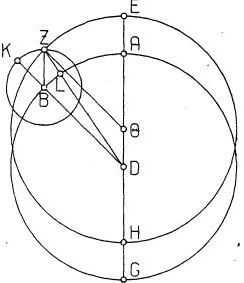

In [12]:
# QUERY IMAGE DEFINITION

# Some possible query images
solar_eccentricity = "toomer/toomer_almagest_p170_0.jpg"
eclipse = "toomer/toomer_almagest_p272_0.jpg"
solar_equation = "toomer/toomer_almagest_p174_0.jpg" # and following 175, 178, 179 & 184
eccentric_epicycle_equivalence = "toomer/toomer_almagest_p165_0.jpg"
planet_anomaly = "toomer/toomer_almagest_p170_0.jpg" # not the right image

""" VARIABLE TO MODIFY """
img_path = eccentric_epicycle_equivalence

query_img = Image.open(img_path).convert('RGB')
display_img(img_path, "🔎 QUERY IMAGE 🔍")

In [13]:
# IMAGE RETRIEVAL
def retrieve_img(query_img, model_name, nb_nn=nb_nearest_neighbors):
    if model_name == "clip":
        # Image retrieval with CLIP
        query_img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        query_feat = clip_model.encode_image(query_img).cpu().detach().numpy()[0]
        cos_sim = []
        for i in range(len(features)):
            cos_sim.append(dot(query_feat, features[i]) / (norm(query_feat) * norm(features[i])))
        return (-np.array(cos_sim)).argsort()[:nb_nn]

    # Compute features for the query image
    query_feat = compute_features(truncated_model, [query_img], size=320, batch_size=10, use_cuda=True)
    # Compute the difference angle between the query image and manuscript images in 
    cos_sim = compute_cosine_matrix(query_feat, feats)
    # Find the nearest_neighbors of query diagram, from cosine metric point of view
    return get_ordered_scores_matrix(cos_sim)[:, :nb_nn], cos_sim

nearest_neighbors, cos_sim = retrieve_img(query_img, model_name, nb_nearest_neighbors)

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


toomer/toomer_almagest_p165_0.jpg
🔎 QUERY IMAGE 🔍


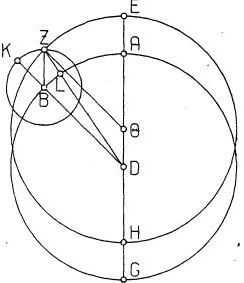

Almageste/btv1b10545065q/f275_1.jpg
0.57562816


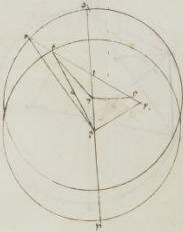

Almageste/btv1b90648533/f37_0.jpg
0.5506456


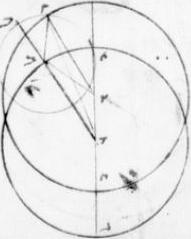

Almageste/btv1b52516888n/f202_1.jpg
0.53872937


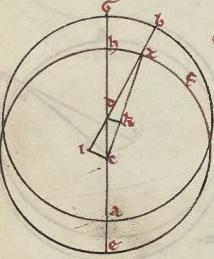

Almageste/btv1b90768493/f104_2.jpg
0.53616434


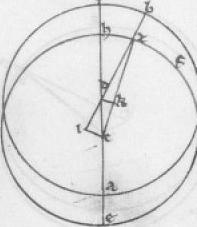

Almageste/btv1b100374763/f100_1.jpg
0.52769065


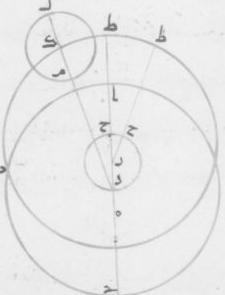

Almageste/btv1b10038233p/f173_0.jpg
0.5249028


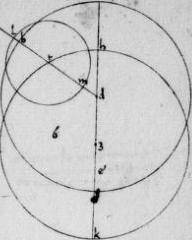

Almageste/btv1b10038053r/f205_0.jpg
0.5211759


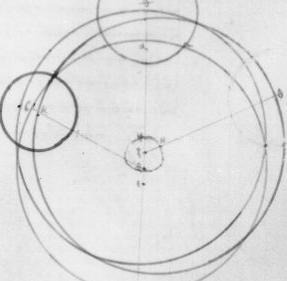

Almageste/btv1b90768493/f102_2.jpg
0.51920015


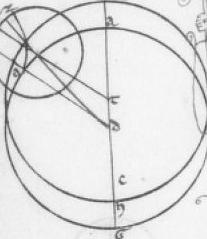

Almageste/btv1b52516888n/f225_0.jpg
0.516829


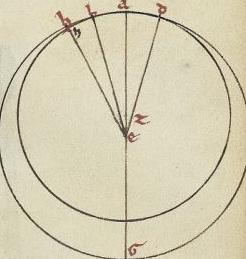

Almageste/btv1b105493907/f81_0.jpg
0.516524


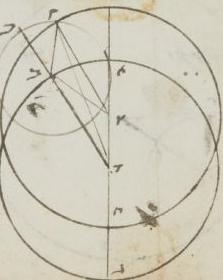

Almageste/btv1b10549389v/f389_0.jpg
0.51149845


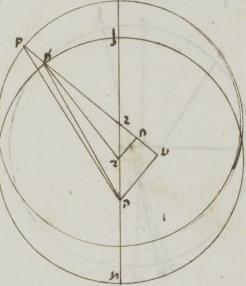

Almageste/btv1b52516888n/f198_0.jpg
0.510199


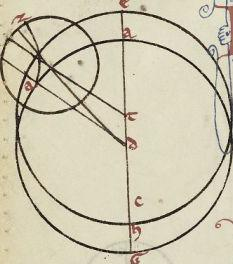

Almageste/btv1b10545065q/f285_1.jpg
0.5097573


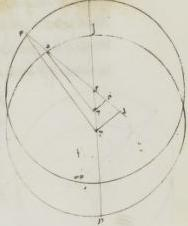

Almageste/btv1b52504628d/f110_0.jpg
0.50931215


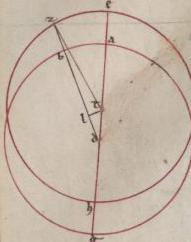

Almageste/btv1b52509699g/f115_1.jpg
0.5092411


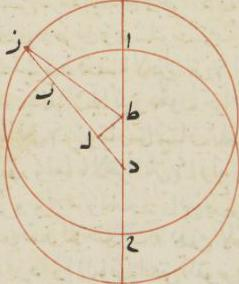

Almageste/btv1b10038233p/f117_1.jpg
0.50734323


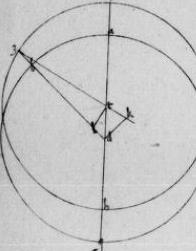

Almageste/btv1b10549389v/f366_0.jpg
0.5067403


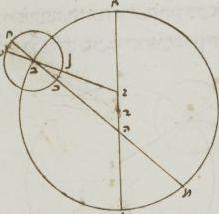

Almageste/btv1b90671704/f120_5.jpg
0.501081


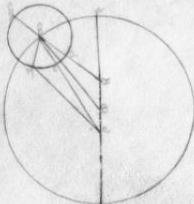

Almageste/btv1b90768493/f109_1.jpg
0.50061005


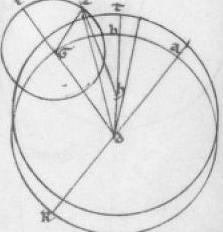

Almageste/btv1b90768493/f103_2.jpg
0.4995751


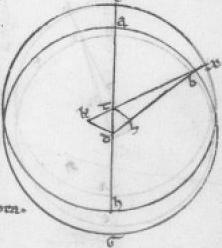

In [14]:
# DISPLAY NEAREST NEIGHBORS
def display_nearest_neighbors(nearest_neighbors, cos_sim, model_name):
    display_img(img_path, "🔎 QUERY IMAGE 🔍")
    if model_name != "clip":
        nearest_neighbors = nearest_neighbors[0]
        cos_sim = cos_sim[0]
    for neighbor in nearest_neighbors:
        display_img(img_paths[neighbor], cos_sim[neighbor])

display_nearest_neighbors(nearest_neighbors, cos_sim, model_name)

In [ ]:
# CSV GENERATION FOR GEPHI
from csv import writer

nn_csv = 'nn1.csv'
def create_csv():
    if os.path.isfile(nn_csv):
        os.remove(nn_csv)
    with open(nn_csv, mode="w", newline='') as csvfile:
        w_csv = csv.writer(csvfile, delimiter=',')
        w_csv.writerow(['img_path', 'query_img', 'score'])
        
def append_to_csv(nearest_neighbors):
    with open(nn_csv, mode="a", newline='') as csvfile:
        w_csv = csv.writer(csvfile)
        for neighbor in nearest_neighbors[0]:
            w_csv.writerow([img_paths[neighbor], img_path, score_matrix[0][neighbor]])

create_csv()

In [ ]:
# Run this cell with different query image results to visualize the diagrams that are the more detected as nn
append_to_csv(nearest_neighbors)

# Diagrams exploration

Now, our goal is to develop (as a team) a new way to navigate into our Astronomical Diagrams corpus: using clustering ([Gaussian mixture](https://scikit-learn.org/stable/modules/mixture.html), [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)), dimensionality reduction ([PCA](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)), visualization tools ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) / [UMAP](https://umap-learn.readthedocs.io/en/latest/), Gephi, large collection dataviz), etc.!

### Visualizations

Examples of use of deep features to navigate into large-scale images / artworks collections:

- [**PixPlot**](https://dhlab.yale.edu/projects/pixplot/) (Yale Digital Humanities Lab): [GitHub](https://github.com/YaleDHLab/pix-plot) / [Example](http://pixplot.yale.edu/v2/loc/)
- [**Suprise machines**](https://www.jbe-platform.com/content/journals/10.1075/idj.22013.rod) (Harvard MetaLAB): [Twitter thread](https://twitter.com/dariorodighiero/status/1591074238378610690)
- [**Nomic**](https://home.nomic.ai/): [MET with CLIP visual embeddings](https://atlas.nomic.ai/map/6f237809-3001-47a4-94da-2bc151cee88d/dad22af1-4ddf-4a0d-8105-f41d2e92b99a)
- [**t-SNE Map**](https://experiments.withgoogle.com/t-sne-map) (Google Arts&Culture / MoMA)
- [**imgs.ai**](https://imgs.ai/interface) (Fabian Offert)

Other types of data-vizualisations:
- [**Coins: Explore visually a large collection**](https://uclab.fh-potsdam.de/coins/): [Codebase](https://github.com/Flave/Muenzkabinett)
- [**Gephi**](https://gephi.org/): Tutorials [[1]](https://docs.google.com/presentation/d/1tnFcRp6l6t64_DNyRZb0O18w1PFhEWA04awlHBNAOv0/edit?usp=sharing) & [[2]](https://docs.google.com/presentation/d/1Os0urAZyk8QQgw60nTgLlRVjbKgXykXta4uBrIKJoY4/edit?usp=sharing) → Try to map differently the columns for nodes/links in order to make apparent 
- [**D3**](https://d3js.org/): [Gallery](https://d3-graph-gallery.com/)

In [ ]:
# GLOBAL IMPORT
import time
import warnings
import pickle as pk

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from umap import UMAP
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [ ]:
""" VARIABLES TO MODIFY """
n_dim = 1000
cluster_nb = 25
k_init = "k-means++" # "random"

In [31]:
# DIMENSIONALITY REDUCTION
def reduce_dim(feats, n_dim=n_dim):
    # Flatten all the features, before applying dimensionality reduction
    flat_feats = np.array([features.flatten() for features in feats])

    # Features reduction using PCA: from 409600 dimensions to n dimensions
    pca = PCA(n_components=n_dim, random_state=22)
    pca.fit(flat_feats)
    reduced_feats = pca.transform(flat_feats)
    print(f"Flatten features: {flat_feats.shape} dimensions" + "\n" +
          f"Reduced features: {reduced_feats.shape} dimensions")
    print(pca.explained_variance_ratio_[:10])
    print(np.sum(pca.explained_variance_ratio_))
    return reduced_feats

reduced_feats = reduce_dim(feats, n_dim)

(3766, 409600)


In [ ]:
# SAVE/UPLOAD PCA
pca_file = 'pca_1000'

def save_pca(pca_file):
    # Save PCA result as binary file
    pk.dump(pca, open(f"{pca_file}.pkl", "wb"))
    pk.dump(reduced_feats, open(f"{pca_file}_results.pkl", "wb"))

def load_pca(pca_file):
    reduced_feats = np.load(f"{pca_file}_results.pkl")

In [ ]:
# GAUSSIAN MIXTURE CLUSTERING
def gaussian_mix(reduced_feats, cluster_nb=cluster_nb):
    '''
    GaussianMixture() parameters
    https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
    '''
    gmixture = GaussianMixture(cluster_nb, random_state=22)
    gmixture.fit(reduced_feats)
    gmixture_labels = gmixture.predict(reduced_feats)

In [ ]:
# KMEANS CLUSTERING
def k_means(reduced_feats, cluster_nb=cluster_nb):
    '''
    KMeans() parameters
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    '''
    kmeans = KMeans(cluster_nb, random_state=22)
    kmeans.fit(reduced_feats)
    centroid_distances = np.empty(shape=(cluster_nb, cluster_nb)) 

    for i in range(cluster_nb):
        for j in range(cluster_nb):
            cluster_center = kmeans.cluster_centers_
            # compute euclidian distances between all clusters centroids
            centroid_distances[i][j] = np.linalg.norm(cluster_center[i] - cluster_center[j])

In [ ]:
# WITHIN-CLUSTER-SUM-OF-SQUARES
def plot_elbow_graph(wcss):
    """
    To choose the number of clusters that is pertinent for the dataset
    """
    plt.plot(range(1,21), wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
def wcss(reduced_feats):
    wcss = []
    # this loop will fit the k-means algorithm to our data and 
    # second we will compute the within cluster sum of squares and happended to our wcss list.
    for i in range(1, 21):
        kmeans = KMeans(n_clusters=i, init=k_init, max_iter=300, n_init=10, random_state=0)
        # n_init which is the number of times the K_means will be run with different initial centroid
        kmeans.fit(reduced_feats)
        wcss.append(kmeans.inertia_)
        # inertia_ = sum of squared distances of samples to their closest cluster center
    plot_elbow_graph(wcss)
    
wcss(reduced_feats)

In [ ]:
kmeans = KMeans(n_clusters=cluster_nb, init=k_init, max_iter=3000)
kmeans_feats = kmeans.fit_predict(reduced_feats)
print(kmeans_feats)

In [ ]:
#%pip install ipympl
#%matplotlib notebook

#Getting unique labels
#%matplotlib notebook
u_labels = np.unique(kmeans_feats)
centroids = model.cluster_centers_
 
#plotting the results:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d') 

for i in u_labels:
    ax.scatter(reduced_feats[kmeans_feats==i, 0], reduced_feats[kmeans_feats==i, 1], label=i, s=10)
plt.scatter(centroids[:,0], centroids[:,1], s=15, color='k')
plt.legend()
plt.show()

In [ ]:
#nearest neighbours
score_center = []
for i in range(centroids.shape[0]) :
    index = np.where(kmeans_feats==i)    
    score_center.append(compute_cosine_matrix(centroids[i],reduced_feats[kmeans_feats==i, :]))  # computes the cosine similarity score matri
center_diagram = get_ordered_scores_matrix(score_center[0], axis=1)[:,:5]

In [ ]:
cluster_order = np.argsort(centroid_distances)[0] #ordering the clusters according to their distance to the first one - in euclidian distance

In [ ]:
#Create a dictionnary to link each cluster to its corresponding images indexes 

groups = {}
for i, cluster in enumerate(kmeans_feats.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

In [ ]:
from numpy import dot
from numpy.linalg import norm
cos_sim = []

for i in range(len(features)):
    cos_sim.append(dot(query_feat, features[i])/(norm(query_feat)*norm(features[i])))

nearest_neighbors = (-np.array(cos_sim)).argsort()[:number_nn]


#nearest_neighbors = []
#for cluster_id in range(n_clust):
#    cos_sim = []
#    for i in range(len(groups[cluster_id])):
#        feat = reduced_feats[groups[cluster_id][i]]
#        cos_sim.append(dot(centroids[cluster_id], feat)/(norm(centroids[cluster_id])*norm(feat)))
#
#    nearest_neighbors.append((-np.array(cos_sim)).argsort()[:5]) #mettre arguments dans argsort good luck

In [ ]:
#Plot the 5 first images of each cluster, according to the cluster order: the closest clusters of the first one, according to euclidian distance
images, images_path = get_images_list('Diagrams') 

for i in cluster_order:
    print(f'Cluster {i}, size: {len(groups[i])}')
    for j in range(min(5,len(groups[i]))):
        print(images_path[groups[i][j]])
        display(images[groups[i][j]])

In [ ]:
#T-SNE reduction in 2D (starting with the features reduced by PCA)

'''
time_start = time.time()
tsne = TSNE(n_components=2)
tsne_embedding = tsne.fit_transform(reduced_feats)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

In [ ]:
#UMAP reduction in 2D (starting with the features reduced by PCA)

reducer = UMAP()
umap_embedding = reducer.fit_transform(reduced_feats)

In [ ]:
#For each cluster point, save its corresponding UMAP coordinates

groups_umap = {}
for umap, cluster in zip(umap_embedding, kmeans_feats.labels_):
    if cluster not in groups_umap.keys():
        groups_umap[cluster] = []
        groups_umap[cluster].append([umap[0],umap[1]])
    else:
        groups_umap[cluster].append([umap[0],umap[1]])

In [ ]:
plt.figure(figsize=(30, 30))
for i in range(len(groups_umap)):
    array = np.array(groups_umap[i])
    plt.scatter(array[:,0],array[:,1], label=f'{i}', color=(np.random.random(), np.random.random(), np.random.random()))
    for j in range(min(10,len(array))):
        plt.annotate(i, (array[j][0], array[j][1]))

plt.xlabel("umap-first-component")
plt.ylabel("umap-second-component")
plt.title('UMAP 2D reduction')
plt.legend()
plt.show()


# Cluster analysis / understanding diagrams typology -> creation of a chosen critical edition

## First, a proper plot (in grid format) of the clusters we are looking at

In [ ]:
#Small function to display PIL images in Grid -> to visualize easely our clusters of interest

def display_images(
    images, 
    columns=5, width=20, height=8, max_images=50, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            plt.title(title, fontsize=label_font_size);

In [ ]:
#Creation of lists of PIL images corresponding to each cluster

images_cluster = [[] for _ in range(len(groups))]

for k in range(len(groups)):
    for i in range(len(groups[k])):
        images[groups[k][i]].filename = images_path[groups[k][i]]
        images_cluster[k].append(images[groups[k][i]])

In [ ]:
#Display cluster of interest

cluster_id = 0

display_images(images_cluster[cluster_id])

## Then, possible use of (more or less simple) image processing to analyze the cluster

### Mean image of each cluster? (simple, but certainly not very useful)

In [ ]:
#Resize all images of interest

images_analysis = []

cluster_id = 0

w, h = 200, 200

for i in range(len(images_cluster[cluster_id])):
    images_analysis.append(images_cluster[cluster_id][i].resize((w,h)))

In [ ]:
#Let's just try creating a "mean" image of our cluster

# Create a numpy array of floats to store the average (assume RGB images)
arr = np.zeros((h,w,3),np.float)

# Build up average pixel intensities, casting each image as an array of floats
for im in images_analysis:
    imarr = np.array(im,dtype=np.float)
    arr = arr+imarr/len(images_analysis)

# Round values in array and cast as 8-bit integer
arr = np.array(np.round(arr),dtype=np.uint8)

# Generate, save and preview final image
out = Image.fromarray(arr,mode="RGB")
display(out)

## Test of feature matching - homography mapping on all diagrams of a cluster?

Some examples / explanations of OpenCV homography / use of RANSAC to estimate homographies:

• https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html

• https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

• https://learnopencv.com/homography-examples-using-opencv-python-c/

• Some explanation slides: http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf

**Paper of interest:**

• RANSAC-Flow: generic two-stage image alignment (Xi Shen): https://imagine.enpc.fr/~shenx/RANSAC-Flow/ 

## Test of binarization of the images?

## Create a critical edition without image processing tools?

• Geogebra: https://www.geogebra.org/?lang=en